<font size="5">

# General considerations for effective thermal neutron shielding in detector applications

<font size="3">

> __Author:__ A. Backis
<br/>__Institute:__ University of Glasgow (UoG), European Spallation Source (ESS)
<br/>__Date:__ 16/2-2022
    
_Abstract:_
This notebook contains the data analysis used in the paper 'General considerations for effective thermal neutron shielding in detector applications'. The aim of the work is provide an analytical framework for comparing the performance different shielding configurations.

# Contents
* [1. Introduction](#INTRODUCTION)
    * [1.1 Overview](#OVERVIEW)
    * [1.2 Packages](#PACKAGES)
    * [1.3 Helper functions](#HELPER_FUNCTIONS)
    * [1.4 Density calculations](#DENSITY_CALCULATIONS)
* [2. Data](#DATA)
* [3. Analysis](#ANALYSIS)
    * [3.1 Cross sections](#CROSS_SECTIONS)
    * [3.2 Transmission & Albedo](#TRANSMISSION_AND_ALBEDO)
    * [3.3 Performance](#PERFORMANCE)
    * [3.4 Comparison with simulation](#COMPARISON_WITH_SIMULATION)
* [Acknowledgements](#ACKNOWLEDGEMENTS)

# 1. Introduction<a class="anchor" id="INTRODUCTION"></a>

The purpose of this notebook is to provide an easy-to-use analytical tool to compare different shielding configurations in terms of performance. This includes details on neutron transmission and albedo probabilities as a function of material thickness and incident neutron energy. It is also to investigate how these propabilities change with material properties such as, for example, $^{10}$B enrichement in B$_4$C. At the last section of the notebook, the analytical calculations are compared to simulated data. The details of how the investigation is performed can be found in the corresponding paper with the same title as this notebook.

## 1.1 Overview<a class="anchor" id="OVERVIEW"></a>

First, the data parser is defined and the data used in the paper is imported and stored in a dictionary. After that, all the analytical calculations done for the paper is performed. Finally, the analytical calculations are compared to simulated data for all materials under investigation.

## 1.2 Packages<a class="anchor" id="PACKAGES"></a>

In [1]:
# Enable autoload of packages when doing an external changes
%load_ext autoreload
%autoreload 2

# General packages
import os
import sys

# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Activate matplotlib in interactive notebook mode
%matplotlib widget

## 1.3 Helper functions<a class="anchor" id="HELPER_FUNCTIONS"></a>

In [2]:
def meV_to_A(energy_in_meV):
    """ Convert neutron energy in millielectronvolts to wavelength in Angstroms.
    
    Args:
        energy_in_meV (float): Neutron energy in [meV]

    Returns:
        wavelength_in_Angstrom (float): Neutron wavelength in [Angstrom]
    
    """
    wavelength_in_Angstrom = np.sqrt(81.81/energy_in_meV)
    return wavelength_in_Angstrom

def A_to_meV(wavelength_in_Angstrom):
    """ Convert neutron wavelength in Angstroms to energy in millielectronvolts.
    
    Args:
        wavelength_in_Angstrom (float): Neutron wavelength in [Angstrom]
        
    Returns:
        energy_in_meV (float): Neutron energy in [meV]
    
    """
    energy_in_meV = (81.81 /(wavelength_in_Angstrom ** 2))
    return energy_in_meV

def set_size(width, fraction=1):
   """Set figure dimensions to avoid scaling in LaTeX.

   Parameters
   ----------
   width: float
           Document textwidth or columnwidth in pts
   fraction: float, optional
           Fraction of the width which you wish the figure to occupy

   Returns
   -------
   fig_dim: tuple
           Dimensions of figure in inches
   """
   # Width of figure (in pts)
   fig_width_pt = width * fraction

   # Convert from pt to inches
   inches_per_pt = 1 / 72.27

   # Golden ratio to set aesthetic figure height
   # https://disq.us/p/2940ij3
   golden_ratio = (5**.5 - 1) / 2

   # Figure width in inches
   fig_width_in = fig_width_pt * inches_per_pt
   # Figure height in inches
   fig_height_in = fig_width_in * golden_ratio

   fig_dim = (fig_width_in, fig_height_in)
   print (fig_dim)
   return fig_dim

def set_style(textwidth=345, columnwidth=0, linewidth=0, paperwidth=0, fraction=1):

    tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    'axes.titlesize': 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.autolimit_mode": "round_numbers",
    "figure.subplot.bottom": 0.17,
    "figure.subplot.right": 0.95,
    "figure.subplot.left": 0.15,
    "figure.figsize": set_size(textwidth) # or above alternatives
    } 
    plt.rcParams.update(tex_fonts)

In [3]:
# Enable LaTeX font plots with the correct font size
set_style()

(4.77376504773765, 2.9503490538081323)


## 1.4 Density calculations<a class="anchor" id="DENSITY_CALCULATIONS"></a>

In [ ]:
def get_mixture_density(w1, w2, d1, d2):
    """
    Function to calculate the density of a mixture of two materials (1) and (2) with
    weight percentages w1 and w2, with corresponding densities d1 and d2.
    
    To do this, we want to find x such that "w1/w2 = (x*d1)/((1-x)*d2)" is satified,
    which can be solved according to "x = (w1*d2)/(w1*d2+w2*d1)". Using the found
    value of x, we can then find the density of the mixture d12 according to
    "d12 = x * d1 + (1-x) * d2". By doing this, we have found a composite mixture
    density that ensures that, for each cm^3, the weight ratio w1/w2 is satisfied
    between the two components.
    
    Args:
        w1 (float): weight percentage of material 1
        w2 (float): weight percentage of material 2
        d1 (float): density of material 1
        d2 (float): density of material 2
        
    Returns:
        d12 (float): Mixture density
    
    """
    # Get x
    x = (w1*d2)/(w1*d2+w2*d1)
    # Get mixture density
    d12 = x * d1 + (1-x) * d2
    return d12
    
# Define component densities (g/cm^3)
epoxy_density = 1.18
Gd2O3_density = 7.407
B4C_20_density = 2.509
B4C_99_density = 2.36560
Al_density = 2.69865

# Get component fractions (these values will be used when creating the Geant4 materials)
epoxy_Gd2O3_35_65_density = get_mixture_density(0.35, 0.65, epoxy_density, Gd2O3_density)
epoxy_Gd2O3_50_50_density = get_mixture_density(0.5, 0.5, epoxy_density, Gd2O3_density)
epoxy_B4C_50_50_natural_density = get_mixture_density(0.5, 0.5, epoxy_density, B4C_20_density)
epoxy_B4C_50_50_enriched_density = get_mixture_density(0.5, 0.5, epoxy_density, B4C_99_density)
boral_90_10 = get_mixture_density(0.9, 0.1, Al_density, B4C_20_density)
boral_33_67 = get_mixture_density(0.33, 0.67, Al_density, B4C_20_density)

# 2. Data<a class="anchor" id="DATA"></a>

First, we define a data parser to import the cross sections from the cross section files.

In [4]:
def parse_data(path):
    """ Function to parse neutron cross sections files generated by the ESS DG framework.

    Args:
        path (str): Path to the data to parse

    Returns:
        data (dict): Dictionary containing two arrays: one with absorption cross sections
                     and one with scattering cross sections (each with corresponding energies in [eV]).
                     The cross sections are stated in [barns].
        density (float): The atomic density [1/cm^3] of the material

    """
    # Get data separators indexes, adjusted for deleted comments lines
    idxs = {'hadElastic': None, 'neutronInelastic': None, 'nCapture': None, 'Total': None}
    with open(path) as f:
        lines = np.array([[line.rstrip(), line.rstrip()[1:8], line.rstrip()[12:]] for line in f]).transpose()
        delimiter_idxs = np.where(lines[1] == 'Process')[0]
        delimiter_processes = lines[2][delimiter_idxs]
        data_start = delimiter_idxs[0]
        data_end = len(lines[0]) - (data_start + 4)
        idx_0 = delimiter_idxs[0] - data_start
        idx_1 = delimiter_idxs[1] - (data_start+1)
        idx_2 = delimiter_idxs[2] - (data_start+2)
        idx_3 = delimiter_idxs[3] - (data_start+3)
        idxs[delimiter_processes[0]] = [idx_0, idx_1]
        idxs[delimiter_processes[1]] = [idx_1, idx_2]
        idxs[delimiter_processes[2]] = [idx_2, idx_3]
        idxs[delimiter_processes[3]] = [idx_3, data_end+1]
    # Get relevant meta-data value
    keys, values = np.loadtxt(path, comments=None, dtype='str', delimiter=': ', max_rows=data_start+1, unpack=True)
    density = float(values[np.where(keys == '#NAtomsPerVolume [1/cm3]')][0])
    # Get data
    energies, xsects = np.loadtxt(path, unpack=True)
    ## hadElastic
    energies_hadElastic = energies[idxs['hadElastic'][0]:idxs['hadElastic'][1]]
    xsects_hadElastic = xsects[idxs['hadElastic'][0]:idxs['hadElastic'][1]]
    ## neutronInelastic
    energies_neutronInelastic = energies[idxs['neutronInelastic'][0]:idxs['neutronInelastic'][1]]
    xsects_neutronInelastic = xsects[idxs['neutronInelastic'][0]:idxs['neutronInelastic'][1]]
    ## nCapture
    energies_nCapture = energies[idxs['nCapture'][0]:idxs['nCapture'][1]]
    xsects_nCapture = xsects[idxs['nCapture'][0]:idxs['nCapture'][1]]
    ## Total
    energies_Total = energies[idxs['Total'][0]:idxs['Total'][1]]
    xsects_Total = xsects[idxs['Total'][0]:idxs['Total'][1]]    
    ## Calculate offset between 'Total' and 'hadElastic'
    offset = np.where(energies_hadElastic == energies_Total[0])[0][0]    
    ## Recalculate to absorption and scattering
    energies_scattering, xsects_scattering = energies_hadElastic, xsects_hadElastic
    energies_absorption, xsects_absorption = energies_Total, (xsects_Total - xsects_hadElastic[offset:])
    ## Cross-check that array operations are correct
    if (sum(energies_Total - energies_hadElastic[offset:])) != 0:
        print('If sum is not zero, something is wrong.')
    # Store data in dictionary
    data = {'absorption': np.array([energies_absorption, xsects_absorption]),
            'scattering': np.array([energies_scattering, xsects_scattering]),
            'total': np.array([energies_Total, xsects_Total])
            }
    return data, density

Then, we import the data and store it in a dictionary called 'data_array'. In the dictionary, each material is represented as a separate small dictionary, which contains the relevant information, such as absorption and scattering cross sections (stored in 'data') as well as density, label and file name.

Additionally, we define 'plot_groups' dictionaries, which contains information for how the plotting should be done. This includes which materials are to be paired (for example natural and enriched B$_4$C), which linestyle and color the plots should have, as well as their respective labels.

In [ ]:
# Declare dictionary to store data
data_array = {'Cd': {'file_name': 'Cd.txt',
                     'label': 'Cadmium',
                     'data': None,
                     'density': None},
              
              'Gd2O3': {'file_name': 'Gd2O3.txt',
                        'label': 'Gd$_2$O$_3$',
                        'data': None,
                        'density': None},
              
              'B4C_nat': {'file_name': 'B4C_nat.txt',
                          'label': 'B$_4$C ($^{10}$B/B: 20 at.%)',
                          'data': None,
                          'density': None},
              
              'B4C_enriched': {'file_name': 'B4C_enriched.txt',
                               'label': 'B$_4$C ($^{10}$B/B: 99 at.%)',
                               'data': None,
                               'density': None},
              
              'LiF_nat': {'file_name': 'LiF_nat.txt',
                          'label': 'LiF ($^{6}$Li/Li: 8 at.%)',
                          'data': None,
                          'density': None},
              
              'LiF_enriched': {'file_name': 'LiF_enriched.txt',
                               'label': 'LiF ($^{6}$Li/Li: 99 at.%)',
                               'data': None,
                               'density': None},
              
              'epoxy_Gd2O3_50_50': {'file_name': 'epoxy_Gd2O3_50_50.txt',
                                    'label': 'epoxy-Gd$_2$O$_3$ (w/w ratio: 50-50)',
                                    'data': None,
                                    'density': None},
              
              'epoxy_Gd2O3_35_65': {'file_name': 'epoxy_Gd2O3_35_65.txt',
                                    'label': 'epoxy-Gd$_2$O$_3$ (w/w ratio: 35-65)',
                                    'data': None,
                                    'density': None},
              
              'epoxy': {'file_name': 'epoxy.txt',
                                     'label': 'Epoxy',
                                     'data': None,
                                     'density': None},
              
              'polyethylene': {'file_name': 'polyethylene.txt',
                               'label': 'Polyethylene',
                               'data': None,
                               'density': None},
              
              'boral_90_10': {'file_name': 'boral_90_10.txt',
                              'label': 'Boral (w/w ratio: 90-10)',
                              'data': None,
                              'density': None},
              
              'boral_33_67': {'file_name': 'boral_33_67.txt',
                              'label': 'Boral (w/w ratio: 33-67)',
                              'data': None,
                              'density': None},
              
              'mirrobor': {'file_name': 'mirrobor.txt',
                              'label': 'MirroBor',
                              'data': None,
                              'density': None},
              
              'Al': {'file_name': 'Al.txt',
                     'label': 'Aluminum',
                     'data': None,
                     'density': None},
              
              'epoxy_b4c_natural': {'file_name': 'epoxy_b4c_50_50_natural.txt',
                                    'label': 'Epoxy-B$_4$C ($^{10}$B/B: 20 at.%)',
                                    'data': None,
                                    'density': None},
              
              'epoxy_b4c_enriched': {'file_name': 'epoxy_b4c_50_50_enriched.txt',
                                     'label': 'Epoxy-B$_4$C ($^{10}$B/B: 99 at.%)',
                                     'data': None,
                                     'density': None}
              }

In [ ]:
# Define plot groups
plot_groups_pure = {'Cd': {'materials': ['Cd'],
                           'color': 'b',
                           'label': 'Cadmium',
                           'linestyle': '-'},
                    
                    'Al': {'materials': ['Al'],
                           'color': 'g',
                           'label': 'Aluminum',
                           'linestyle': '--'}
                    }
               
plot_groups_molecules = {'Gd2O3': {'materials': ['Gd2O3'],
                                   'color': 'r',
                                   'label': 'Gd$_2$O$_3$',
                                   'linestyle': '-'},
                         
                         'B4C': {'materials': ['B4C_nat', 'B4C_enriched'],
                                 'color': 'c',
                                 'label': 'B$_4$C',
                                 'linestyle': '-.'},
                         
                         'LiF': {'materials': ['LiF_nat', 'LiF_enriched'],
                                 'color': 'm',
                                 'label': 'LiF',
                                 'linestyle': (0, (3, 5, 1, 5, 1, 5))},
                         
                         'epoxy': {'materials': ['epoxy'],
                                   'color': 'orange',
                                   'label': 'Epoxy',
                                   'linestyle': '--'},
                         
                         'polyethylene': {'materials': ['polyethylene'],
                                          'color': 'k',
                                          'label': 'Polyethylene',
                                          'linestyle': 'dotted'}
                         }

plot_groups_compounds = {'epoxy_Gd2O3': {'materials': ['epoxy_Gd2O3_50_50', 'epoxy_Gd2O3_35_65'],
                                         'color': 'grey',
                                         'label': 'Epoxy-Gd$_2$O$_3$',
                                         'linestyle': '--'},

                         'epoxy_B4C': {'materials': ['epoxy_b4c_natural', 'epoxy_b4c_enriched'],
                                       'color': 'chocolate',
                                       'label': 'Epoxy-B$_4$C',
                                       'linestyle': 'dotted'},
    
                         'boral': {'materials': ['boral_90_10', 'boral_33_67'],
                                   'color': 'lime',
                                   'label': 'Boral',
                                   'linestyle': '-.'},
    
                         'mirrobor': {'materials': ['mirrobor'],
                                      'color': 'purple',
                                      'label': 'MirroBor',
                                      'linestyle': '-'}
                         }

In [ ]:
# Import data
for material in data_array.keys():
    # Get data and density
    file_name = data_array[material]['file_name']
    path = 'data/material_data/%s' % file_name
    data, density = parse_data(path)
    # Store in array
    data_array[material]['data'] = data
    data_array[material]['density'] = density

# 3. Analysis<a class="anchor" id="ANALYSIS"></a>

## 3.1 Cross sections<a class="anchor" id="CROSS_SECTIONS"></a>

First, we define a function to plot the absorption and scattering cross sections (in barns) as a function of neutron energy (in meV) for all materials under investigation.

In [ ]:
def plot_microscopic_sigma_full(data_array, plot_types, ymin=1e-2, ymax=1e10):
    """ Function to plot absorption and scattering microscopic cross sections.

    Args:
        data_array (dict): Dictionary containing all relevant material data
        plot_types (list): List containing plot-group dictionaries of the materials under investigation. These
                           dictionaries contain all information for how the plotting should be done.
                           This includes which materials are to be paired (for example natural and enriched B4C),
                           which linestyle and color the plots should have, as well as labels.
        ymin (float): Minimum y-value of plot (in barns)
        ymax (float): Maximum y-value of plot (in barns)

    Yields:
        Plots depicting the absorption and scattering microscopic cross sections. The plot is also saved in the 
        'output'-folder.

    """
    # Prepare plot
    barn_to_cm2 = 1e-24
    tick_locs = np.array([1e-1, 1e0, 1e1, 1e2, 1e3]) # 3.2724
    tick_labels = [round(meV_to_A(tick), 1) for tick in tick_locs]
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True)
    ax7 = ax1.twiny()
    ax7.set_xlim(1e-1, 1e3)
    ax7.set_xscale('log')
    ax7.set_xticks(tick_locs)
    ax7.set_xticklabels(tick_labels)
    ax7.set_xlabel('Wavelength (Å)')
    ax7.minorticks_off()
    ax8 = ax2.twiny()
    ax8.set_xlim(1e-1, 1e3)
    ax8.set_xscale('log')
    ax8.set_xticks(tick_locs)
    ax8.set_xticklabels(tick_labels)
    ax8.set_xlabel('Wavelength (Å)')
    ax8.minorticks_off()
    ax9 = ax2.twinx()
    ax9.set_ylim(ymin*barn_to_cm2, ymax*barn_to_cm2)
    ax9.set_yscale('log')
    ax9.set_ylabel('$\overline{\sigma}$ (cm$^2$)')
    ax9.set_yticks([1e-26, 1e-25, 1e-24, 1e-23, 1e-22, 1e-21, 1e-20, 1e-19, 1e-18])
    ax10 = ax4.twinx()
    ax10.set_ylim(ymin*barn_to_cm2, ymax*barn_to_cm2)
    ax10.set_yscale('log')
    ax10.set_ylabel('$\overline{\sigma}$ (cm$^2$)')
    ax10.set_yticks([1e-26, 1e-25, 1e-24, 1e-23, 1e-22, 1e-21, 1e-20, 1e-19, 1e-18])
    ax11 = ax6.twinx()
    ax11.set_ylim(ymin*barn_to_cm2, ymax*barn_to_cm2)
    ax11.set_yscale('log')
    ax11.set_ylabel('$\overline{\sigma}$ (cm$^2$)')
    ax11.set_yticks([1e-26, 1e-25, 1e-24, 1e-23, 1e-22, 1e-21, 1e-20, 1e-19, 1e-18])
    axes = [[ax1, ax2], [ax3, ax4], [ax5, ax6]]
    legend_labels = ['Elements', 'Molecules', 'Compounds']
    # Plot cross sections from all materials
    for i, plot_groups in enumerate(plot_types):
        axA, axB = axes[i]
        legend_label = legend_labels[i]
        for plot_group in plot_groups.values():
            # Extract values
            materials = plot_group['materials']
            color = plot_group['color']
            label = plot_group['label']
            linestyle = plot_group['linestyle']
            # Plot values
            if len(materials) == 1:
                # Extract values
                material = materials[0]
                data = data_array[material]['data']
                abs_cross, scatter_cross = data['absorption'], data['scattering']
                # Plot
                axA.plot(abs_cross[0]*1000, abs_cross[1], color=color, label=label, linestyle=linestyle)
                axB.plot(scatter_cross[0]*1000, scatter_cross[1], color=color, label=label, linestyle=linestyle)
            else:
                # Extract values
                material_1, material_2 = materials[0], materials[1]
                data_1, data_2 = data_array[material_1]['data'], data_array[material_2]['data']
                abs_cross_1, abs_cross_2 = data_1['absorption'], data_2['absorption']
                scatter_cross_1, scatter_cross_2 = data_1['scattering'], data_2['scattering']
                # Plot
                axA.plot(abs_cross_1[0]*1000, abs_cross_1[1], color=color, label=None, linestyle=linestyle)
                axA.plot(abs_cross_2[0]*1000, abs_cross_2[1], color=color, label=None, linestyle=linestyle)
                axA.fill_between(abs_cross_1[0]*1000, abs_cross_2[1], abs_cross_1[1],
                                 color=color, label=label, alpha=0.3)
                axB.plot(scatter_cross_1[0]*1000, scatter_cross_1[1], color=color, label=None,
                         linestyle=linestyle)
                axB.plot(scatter_cross_2[0]*1000, scatter_cross_2[1], color=color, label=None,
                         linestyle=linestyle)
                axB.fill_between(scatter_cross_1[0]*1000, scatter_cross_2[1], scatter_cross_1[1],
                                 color=color, label=label, alpha=0.3)
        # Stylize plot
        axA.set_xscale('log')
        axA.set_yscale('log')
        axA.set_ylabel('$\overline{\sigma}$ (barn)')
        axA.grid(True, which='major', linestyle='--', zorder=0)
        axA.grid(True, which='minor', linestyle='--', zorder=0)
        axA.set_ylim(ymin, ymax)
        axA.set_xlim(1e-1, 1000)
        axB.set_xscale('log')
        axB.set_yscale('log')
        axB.grid(True, which='major', linestyle='--', zorder=0)
        axB.grid(True, which='minor', linestyle='--', zorder=0)
        axB.set_xlim(1e-1, 1000)
        axA.set_yticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
    
    ax1.add_artist(AnchoredText("Absorption", loc=9))
    ax2.add_artist(AnchoredText("Scattering", loc=9))
    ax5.set_xlabel('Energy (meV)')
    ax6.set_xlabel('Energy (meV)')
    
    plt.subplots_adjust(wspace=.15)
    plt.subplots_adjust(hspace=.5)
    
    # Define legends
    legend_1 = [Line2D([0], [0], color='b', label='Cadmium', linestyle='-'),
                Line2D([0], [0], color='g', label='Aluminum', linestyle='--')]
    legend_2 = [Line2D([0], [0], color='r', label='Gd$_2$O$_3$', linestyle='-'),
                Line2D([0], [0], color='orange', label='Epoxy', linestyle='--'),
                Line2D([0], [0], color='k', label='Polyethylene', linestyle='dotted'),
                Patch(facecolor='c', label='B$_4$C', alpha=0.3, edgecolor='c'),
                Patch(facecolor='purple', label='LiF', alpha=0.3, edgecolor='purple')]
    legend_3 = [Line2D([0], [0], color='purple', label='MirroBor', linestyle='-'),
                Patch(facecolor='grey', label='Epoxy-Gd$_2$O$_3$', alpha=0.3, edgecolor='grey'),
                Patch(facecolor='chocolate', label='Epoxy-B$_4$C', alpha=0.3, edgecolor='chocolate'),
                Patch(facecolor='lime', label='Boral', alpha=0.3, edgecolor='lime')]

    fig.legend(bbox_to_anchor=(0.77, 0.975), handles=legend_1, ncol=2, title='Elements')
    fig.legend(bbox_to_anchor=(1.01, 0.675), handles=legend_2, ncol=5, title='Molecules')
    fig.legend(bbox_to_anchor=(0.985, 0.41), handles=legend_3, ncol=4, title='Compounds')
    fig.set_figheight(9)
    fig.set_figwidth(4.77376504773765)

    # Save plot
    fig.savefig('output/full_microscopic_sigma_vs_mev.pdf', bbox_inches='tight')

In [ ]:
def plot_macroscopic_sigma_full(data_array, plot_types, ymin=1e-2, ymax=1e10):
    """ Function to plot absorption and scattering macroscopic cross sections.

    Args:
        data_array (dict): Dictionary containing all relevant material data
        plot_types (list): List containing plot-groups dictionaries of the materials under investigation. These
                           dictionaries contain all information for how the plotting should be done.
                           This includes which materials are to be paired (for example natural and enriched B4C),
                           which linestyle and color the plots should have, as well as labels.
        ymin (float): Minimum y-value of plot (in barns)
        ymax (float): Maximum y-value of plot (in barns)

    Yields:
        Plots depicting the absorption and scattering macroscopic cross sections. The plot is also saved in the 
        'output'-folder.

    """
    # Prepare plot
    barn_to_cm2 = 1e-24
    tick_locs = np.array([1e-1, 1e0, 1e1, 1e2, 1e3])
    tick_labels = [round(meV_to_A(tick), 1) for tick in tick_locs]
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True)
    ax7 = ax1.twiny()
    ax7.set_xlim(1e-1, 1e3)
    ax7.set_xscale('log')
    ax7.set_xticks(tick_locs)
    ax7.set_xticklabels(tick_labels)
    ax7.set_xlabel('Wavelength (Å)')
    ax7.minorticks_off()
    ax8 = ax2.twiny()
    ax8.set_xlim(1e-1, 1e3)
    ax8.set_xscale('log')
    ax8.set_xticks(tick_locs)
    ax8.set_xticklabels(tick_labels)
    ax8.set_xlabel('Wavelength (Å)')
    ax8.minorticks_off()
    plt.subplots_adjust(wspace=.01)
    axes = [[ax1, ax2], [ax3, ax4], [ax5, ax6]]
    legend_labels = ['Elements', 'Molecules', 'Compounds']
    # Plot cross sections from all materials
    for i, plot_groups in enumerate(plot_types):
        axA, axB = axes[i]
        legend_label = legend_labels[i]
        for plot_group in plot_groups.values():
            # Extract values
            materials = plot_group['materials']
            color = plot_group['color']
            label = plot_group['label']
            linestyle = plot_group['linestyle']
            # Plot values
            if len(materials) == 1:
                # Extract values
                material = materials[0]
                data = data_array[material]['data']
                density = data_array[material]['density']
                abs_cross, scatter_cross = data['absorption'], data['scattering']
                abs_macro_cross = abs_cross[1] * barn_to_cm2 * density
                scatter_macro_cross = scatter_cross[1] * barn_to_cm2 * density
                # Plot
                axA.plot(abs_cross[0]*1000, abs_macro_cross, color=color, label=label, linestyle=linestyle)
                axB.plot(scatter_cross[0]*1000, scatter_macro_cross, color=color, label=label,
                         linestyle=linestyle)
            else:
                # Extract values
                material_1, material_2 = materials[0], materials[1]
                density_1, density_2 = data_array[material_1]['density'], data_array[material_2]['density']
                data_1, data_2 = data_array[material_1]['data'], data_array[material_2]['data']
                abs_cross_1, abs_cross_2 = data_1['absorption'], data_2['absorption']
                scatter_cross_1, scatter_cross_2 = data_1['scattering'], data_2['scattering']
                abs_macro_cross_1 = abs_cross_1[1] * barn_to_cm2 * density_1
                scatter_macro_cross_1 = scatter_cross_1[1] * barn_to_cm2 * density_1
                abs_macro_cross_2 = abs_cross_2[1] * barn_to_cm2 * density_2
                scatter_macro_cross_2 = scatter_cross_2[1] * barn_to_cm2 * density_2
                # Plot
                axA.plot(abs_cross_1[0]*1000, abs_macro_cross_1, color=color, label=None, linestyle=linestyle)
                axA.plot(abs_cross_2[0]*1000, abs_macro_cross_2, color=color, label=None, linestyle=linestyle)
                axA.fill_between(abs_cross_1[0]*1000, abs_macro_cross_2, abs_macro_cross_1,
                                 color=color, label=label, alpha=0.3)
                axB.plot(scatter_cross_1[0]*1000, scatter_macro_cross_1, color=color, label=None,
                         linestyle=linestyle)
                axB.plot(scatter_cross_2[0]*1000, scatter_macro_cross_2, color=color, label=None,
                         linestyle=linestyle)
                axB.fill_between(scatter_cross_1[0]*1000, scatter_macro_cross_2, scatter_macro_cross_1,
                                 color=color, label=label, alpha=0.3)
        # Stylize plot
        axA.set_xscale('log')
        axA.set_yscale('log')
        axA.set_ylabel('$\overline{\Sigma}$ (cm$^{-1}$)')
        axA.grid(True, which='major', linestyle='--', zorder=0)
        axA.grid(True, which='minor', linestyle='--', zorder=0)
        axA.set_ylim(ymin, ymax)
        axA.set_xlim(1e-1, 1000)
    
        axB.set_xscale('log')
        axB.set_yscale('log')
        axB.grid(True, which='major', linestyle='--', zorder=0)
        axB.grid(True, which='minor', linestyle='--', zorder=0)
        axB.set_xlim(1e-1, 1000)
        
        axA.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5])
    
    ax1.add_artist(AnchoredText("Absorption", loc=9))
    ax2.add_artist(AnchoredText("Scattering", loc=9))
    ax5.set_xlabel('Energy (meV)')
    ax6.set_xlabel('Energy (meV)')
    # Define legends
    legend_1 = [Line2D([0], [0], color='b', label='Cadmium', linestyle='-'),
                Line2D([0], [0], color='g', label='Aluminum', linestyle='--')]
    legend_2 = [Line2D([0], [0], color='r', label='Gd$_2$O$_3$', linestyle='-'),
                Line2D([0], [0], color='orange', label='Epoxy', linestyle='--'),
                Line2D([0], [0], color='k', label='Polyethylene', linestyle='dotted'),
                Patch(facecolor='c', label='B$_4$C', alpha=0.3, edgecolor='c'),
                Patch(facecolor='purple', label='LiF', alpha=0.3, edgecolor='purple')]
    legend_3 = [Line2D([0], [0], color='purple', label='MirroBor', linestyle='-'),
                Patch(facecolor='grey', label='Epoxy-Gd$_2$O$_3$', alpha=0.3, edgecolor='grey'),
                Patch(facecolor='chocolate', label='Epoxy-B$_4$C', alpha=0.3, edgecolor='chocolate'),
                Patch(facecolor='lime', label='Boral', alpha=0.3, edgecolor='lime')]
    
    plt.subplots_adjust(wspace=.15)
    plt.subplots_adjust(hspace=.5)

    fig.legend(bbox_to_anchor=(0.77, 0.98), handles=legend_1, ncol=2, title='Elements')
    fig.legend(bbox_to_anchor=(1.01, 0.675), handles=legend_2, ncol=5, title='Molecules')
    fig.legend(bbox_to_anchor=(0.985, 0.410), handles=legend_3, ncol=4, title='Compounds')
    fig.set_figheight(9)
    fig.set_figwidth(4.77376504773765)

    # Save plot
    fig.savefig('output/macroscopic_sigma_vs_mev_full.pdf', bbox_inches='tight')

Then we plot the cross sections for all materials under investigation.

In [ ]:
plot_types = [plot_groups_pure, plot_groups_molecules, plot_groups_compounds]
plot_microscopic_sigma_full(data_array, plot_types, ymin=1e-2, ymax=1e6)
plot_macroscopic_sigma_full(data_array, plot_types, ymin=1e-3, ymax=1e5)

## 3.2. Transmission & Albedo<a class="anchor" id="TRANSMISSION_AND_ALBEDO"></a>

First, we define a set of useful helper functions.

In [ ]:
def get_idx_closest(array, value):
    """ Returns the index of the floating number which is the closest to the value 'value' in the array 'array'.

    Args:
        array (numpy.array): Array to be searched
        value (float): Number to be compared with the array elements

    Returns:
        idx_closest (int): Index of closest value in array
        
    """
    idx_closest = min(enumerate(array), key=lambda x: abs(x[1]-value))[0]
    return idx_closest

def get_sigma_of_energy(energy_and_cross, energy):
    """ Returns the cross section 'sigma' corresponding to the closest
        energy to 'energy' in the array 'energy_and_cross'.

    Args:
        energy_and_cross (numpy.array): Array to be searched for the closest cross section
        energy (float): Energy to which the corresponding cross section should be found

    Returns:
        sigma (float): Cross section corresponding to the closest energy to 'energy'
                       in the array 'energy_and_cross', in units [barn].
    """
    sigma = energy_and_cross[1][get_idx_closest(energy_and_cross[0], energy)]
    return sigma

def get_probability(sigma, density, thickness):
    """ Returns the neutron interaction probability corresponding to the
        cross section 'sigma', density 'density' and material thickness 'thickness'.

    Args:
        sigma (float): Cross section in unit [cm^2]
        density (float): Density in unit [1/cm^3] (#atoms per cubic cm)
        thickness (float): Thickness in unit [cm]

    Returns:
        interaction_probability (float): Neutron interaction probability corresponding
                                         to the cross section, density and material thickness entered.
                                         
    """
    interaction_probability = 1 - np.exp(-sigma*density*thickness)
    return interaction_probability

def get_transmission(p_absorption, p_scattering):
    """ Returns transmission as a function of thickness.

    Args:
        p_absorption (np.array): Absorption as a function of thickness (strictly increasing thicknesses)
        p_scattering (np.array): Scattering as a function of thickness (strictly increasing thicknesses)

    Returns:
        p_transmission (np.array): Transmission as a function of thickness (strictly increasing thicknesses)
        
    """
    p_transmission = (1 - p_absorption) * (1 - 0.5*p_scattering)
    return p_transmission

def get_albedo(p_absorption, p_scattering):
    """ Returns albedo as a function of thickness.

    Args:
        p_absorption (np.array): Absorption as a function of thickness (strictly increasing thicknesses)
        p_scattering (np.array): Scattering as a function of thickness (strictly increasing thicknesses)

    Returns:
        p_albedo (np.array): Albedo as a function of thickness (strictly increasing thicknesses)
        
    """
    p_albedo_elements = ((1 - p_absorption[1:]) ** 2) * 0.5 * np.diff(p_scattering)
    p_albedo = np.empty([len(p_albedo_elements)], dtype='float')
    for i in range(0, len(p_albedo_elements)):
        p_albedo[i] = sum(p_albedo_elements[:i+1])
    return p_albedo

def get_prob_vs_thickness(data, energy, density, thicknesses):
    """ Returns transmission and albedo as a function of thickness.

    Args:
        data (dict): Dictionary containing two arrays: one with absorption cross sections
                     and one with scattering cross sections (each with corresponding energies in [eV]).
                     The cross sections are stated in barns.
        energy (float): Energy in [eV]
        density (float): Density expressed in [1/3cm^3]
        thicknesses (np.array): Thicknesses in [cm] 

    Returns:
        p_transmission (np.array): Transmission as a function of thickness (strictly increasing thicknesses)
        p_albedo (np.array): Albedo as a function of thickness (strictly increasing thicknesses)
        
    """
    # Declare parameters
    barn_to_cm2 = 1e-24
    # Extract cross sections
    sigma_absorption = get_sigma_of_energy(data['absorption'], energy) * barn_to_cm2
    sigma_scattering = get_sigma_of_energy(data['scattering'], energy) * barn_to_cm2
    # Get scattering and absorption probabilities
    p_absorption = get_probability(sigma_absorption, density, thicknesses)
    p_scattering = get_probability(sigma_scattering, density, thicknesses)
    # Get transmission and albedo
    p_transmission = get_transmission(p_absorption, p_scattering)
    p_albedo = get_albedo(p_absorption, p_scattering)
    return p_transmission, p_albedo

Then, we define a function to plot transmission and albedo as a function of material thickness, for a fixed energy.

In [ ]:
def plot_transmission_and_albedo_full(plot_types, data_array, energy):
    """ Function to plot transmission and albedo as a function of thickness.

    Args:
        plot_types (list): List containing plot-groups dictionaries of the materials under investigation. These
                           dictionaries contain all information for how the plotting should be done.
                           This includes which materials are to be paired (for example natural and enriched B4C),
                           which linestyle and color the plots should have, as well as labels.
        data_array (dict): Dictionary containg all relevant material data
        energy (float): Energy in [eV]

    Yields:
        Plot depicting the transmission and albedo probabilities as a function of thickness.
        The plot is also saved in the 'output'-folder.

    """
    # Declare parameters
    xmin, xmax = 1e-3, 1e2
    ymin, ymax = 1e-5, 1
    thicknesses = np.logspace(-7, 2, 1000) * 0.1  # in cm
    # Prepare plot
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True)
    axes = [[ax1, ax2], [ax3, ax4], [ax5, ax6]]
    legend_labels = ['Elements', 'Molecules', 'Compounds']
    # Plot cross sections from all materials
    for i, plot_groups in enumerate(plot_types):
        axA, axB = axes[i]
        legend_label = legend_labels[i]
        # Plot cross sections from all materials
        for plot_group in plot_groups.values():
            # Extract values
            materials = plot_group['materials']
            color = plot_group['color']
            label = plot_group['label']
            linestyle = plot_group['linestyle']
            # Plot values
            if len(materials) == 1:
                # Extract values
                material = materials[0]
                data = data_array[material]['data']
                density = data_array[material]['density']
                # Calculate probabilities
                p_transmission, p_albedo = get_prob_vs_thickness(data, energy, density, thicknesses)
                # Plot
                axA.plot(thicknesses*10, p_transmission, color=color, label=label, linestyle=linestyle)
                axB.plot(thicknesses[1:]*10, p_albedo, color=color, label=label, linestyle=linestyle)
            else:
                # Extract values
                material_1, material_2 = materials[0], materials[1]
                data_1, data_2 = data_array[material_1]['data'], data_array[material_2]['data']
                density_1, density_2 = data_array[material_1]['density'], data_array[material_2]['density']
                # Calculate probabilites
                p_transmission_1, p_albedo_1 = get_prob_vs_thickness(data_1, energy, density_1, thicknesses)
                p_transmission_2, p_albedo_2 = get_prob_vs_thickness(data_2, energy, density_2, thicknesses)
                # Plot
                axA.plot(thicknesses*10, p_transmission_1, color=color, label=None, linestyle=linestyle)
                axA.plot(thicknesses*10, p_transmission_2, color=color, label=None, linestyle=linestyle)
                axA.fill_between(thicknesses*10, p_transmission_2, p_transmission_1,
                                 color=color, label=label, alpha=0.3)
                axB.plot(thicknesses[1:]*10, p_albedo_1, color=color, label=None, linestyle=linestyle)
                axB.plot(thicknesses[1:]*10, p_albedo_2, color=color, label=None, linestyle=linestyle)
                axB.fill_between(thicknesses[1:]*10, p_albedo_2, p_albedo_1,
                                 color=color, label=label, alpha=0.3)
        # Stylize plot
        axA.set_xscale('log')
        axA.set_yscale('log')
        axA.set_ylabel('Probability')
        axA.grid(True, which='major', linestyle='--', zorder=0)
        axA.grid(True, which='minor', linestyle='--', zorder=0)
        axA.set_xlim(xmin, xmax)
        axA.set_ylim(ymin, ymax)
        axB.set_xlim(xmin, xmax)
        axB.set_xscale('log')
        axB.set_yscale('log')
        axB.grid(True, which='major', linestyle='--', zorder=0)
        axB.grid(True, which='minor', linestyle='--', zorder=0)
    
    ax1.add_artist(AnchoredText("Transmission", loc=9))
    ax2.add_artist(AnchoredText("Albedo", loc=9))
    ax5.set_xlabel('Thickness (mm)')
    ax6.set_xlabel('Thickness (mm)')
    ax5.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
    ax6.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
    
    # Define legends
    legend_1 = [Line2D([0], [0], color='b', label='Cadmium', linestyle='-'),
                Line2D([0], [0], color='g', label='Aluminum', linestyle='--')]
    legend_2 = [Line2D([0], [0], color='r', label='Gd$_2$O$_3$', linestyle='-'),
                Line2D([0], [0], color='orange', label='Epoxy', linestyle='--'),
                Line2D([0], [0], color='k', label='Polyethylene', linestyle='dotted'),
                Patch(facecolor='c', label='B$_4$C', alpha=0.3, edgecolor='c'),
                Patch(facecolor='purple', label='LiF', alpha=0.3, edgecolor='purple')]
    legend_3 = [Line2D([0], [0], color='purple', label='MirroBor', linestyle='-'),
                Patch(facecolor='grey', label='Epoxy-Gd$_2$O$_3$', alpha=0.3, edgecolor='grey'),
                Patch(facecolor='chocolate', label='Epoxy-B$_4$C', alpha=0.3, edgecolor='chocolate'),
                Patch(facecolor='lime', label='Boral', alpha=0.3, edgecolor='lime')]
    
    plt.subplots_adjust(wspace=.15)
    plt.subplots_adjust(hspace=.5)

    fig.legend(bbox_to_anchor=(0.77, 0.94), handles=legend_1, ncol=2, title='Elements')
    fig.legend(bbox_to_anchor=(1.01, 0.675), handles=legend_2, ncol=5, title='Molecules')
    fig.legend(bbox_to_anchor=(0.985, 0.41), handles=legend_3, ncol=4, title='Compounds')
    fig.set_figheight(9)
    fig.set_figwidth(4.77376504773765)
    
    # Save plot
    fig.savefig('output/albedo_and_transmission_at_%.4f_eV_full.pdf' % energy, bbox_inches='tight')

Finally, we run the script for 25 meV neutrons.

In [ ]:
plot_types = [plot_groups_pure, plot_groups_molecules, plot_groups_compounds]
plot_transmission_and_albedo_full(plot_types, data_array, 0.02525)

## 3.3. Performance<a class="anchor" id="PERFORMANCE"></a>

First, we declare a helper function to get the Albedo saturation level.

In [ ]:
def get_albedo_saturation(thicknesses, p_albedo, p_transmission, saturation_fraction=0.95):
    """ Returns the thickness for which the albedo level saturates, the corresponding albedo saturation level,
        as well as the ratio between transmission and albedo at that thickness.

    Args:
        thicknesses (np.array): Thicknesses in [cm]
        p_albedo (np.array): Albedo as a function of thickness (strictly increasing thicknesses)
        p_transmission (np.array): Transmission as a function of thickness (strictly increasing thicknesses)
        saturation_fraction (float): The fraction of maximum albedo level at which the albedo is considered
                                     saturated. The reason this is necessary is because the albedo saturation
                                     has log-like behaviour and the saturation converges very slowly towards
                                     its maximum.

    Returns:
        albedo_saturation_thickness (float): Thickness in [cm] for which the albedo level is saturated
        albedo_saturation_level (float): Albedo saturation level
        transmission_albedo_fraction (float): Ratio between transmission and albedo at the albedo
                                              saturation thickness.  

    """
    albedo_saturation_level = max(p_albedo) * saturation_fraction
    albedo_saturation_idx = np.where(p_albedo >= albedo_saturation_level)[0][0]
    albedo_saturation_thickness = thicknesses[1:][albedo_saturation_idx]
    transmission_albedo_fraction = p_transmission[1:][albedo_saturation_idx]/albedo_saturation_level
    return albedo_saturation_thickness, albedo_saturation_level, transmission_albedo_fraction

Then, we declare the code to calculate the albedo saturation as a function of energy.

In [ ]:
def plot_albedo_sat_and_frac(plot_types, data_array, number_elements):
    """ Function to plot the albedo saturation level as a function of energy, as well as the
        fraction between transmission and albedo at the albedo saturation thickness.

    Args:
        plot_types (list): List containing plot-groups dictionaries of the materials under investigation. These
                           dictionaries contain all information for how the plotting should be done.
                           This includes which materials are to be paired (for example, natural and enriched B4C),
                           which linestyle and color the plots should have, as well as labels.
        data_array (dict): Dictionary containg all relevant material data
        number_elements (int): Number of elements to use in the 'thicknesses' and 'energies' arrays.

    Yields:
        Plots depicting the albedo saturation level as a function of energy, as well as the
        fraction between transmission and albedo at the albedo saturation thickness. The plot is also saved
        in the 'output'-folder.

    """
    # Declare parameters
    thicknesses = np.logspace(-7, 2, number_elements) * 0.1  # The unit must be in cm
    energies = np.logspace(-5, 0, number_elements)
    # Prepare plot
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, sharex=True)
    tick_locs = np.array([1e-1, 1e0, 1e1, 1e2, 1e3]) # 3.2724
    tick_labels = [round(meV_to_A(tick), 1) for tick in tick_locs]
    ax7 = ax1.twiny()
    ax7.set_xlim(1e-1, 1e3)
    ax7.set_xscale('log')
    ax7.set_xticks(tick_locs)
    ax7.set_xticklabels(tick_labels)
    ax7.set_xlabel('Wavelength (Å)')
    ax8 = ax2.twiny()
    ax8.set_xlim(1e-1, 1e3)
    ax8.set_xscale('log')
    ax8.set_xticks(tick_locs)
    ax8.set_xticklabels(tick_labels)
    ax8.set_xlabel('Wavelength (Å)')
    axes = [[ax1, ax2], [ax3, ax4], [ax5, ax6]]
    legend_labels = ['Elements', 'Molecules', 'Compounds']
    # Plot cross sections from all materials
    for i, plot_groups in enumerate(plot_types):
        axA, axB = axes[i]
        legend_label = legend_labels[i]
        # Plot cross sections from all materials
        for plot_group in plot_groups.values():
            # Extract values
            materials = plot_group['materials']
            color = plot_group['color']
            label = plot_group['label']
            linestyle = plot_group['linestyle']
            # Plot values
            if len(materials) == 1:
                # Extract avlues
                material = materials[0]
                data = data_array[material]['data']
                density = data_array[material]['density']
                # Calculate probabilities
                sat_levels = np.empty([len(energies)], dtype='float')
                sat_fracs = np.empty([len(energies)], dtype='float')
                for i, energy in enumerate(energies):
                    p_transmission, p_albedo = get_prob_vs_thickness(data, energy, density, thicknesses)
                    sat_thick, sat_level, sat_frac = get_albedo_saturation(thicknesses, p_albedo, p_transmission)
                    sat_levels[i] = sat_level
                    sat_fracs[i] = sat_frac
                # Plot
                axA.plot(energies*1e3, sat_levels, color=color, label=label, linestyle=linestyle)
                axB.plot(energies*1e3, sat_fracs, color=color, label=label, linestyle=linestyle)
            else:
                # Extract values
                material_1, material_2 = materials[0], materials[1]
                data_1, data_2 = data_array[material_1]['data'], data_array[material_2]['data']
                density_1, density_2 = data_array[material_1]['density'], data_array[material_2]['density']
                # Calculate probabilities
                sat_levels_1 = np.empty([len(energies)], dtype='float')
                sat_fracs_1 = np.empty([len(energies)], dtype='float')
                sat_levels_2 = np.empty([len(energies)], dtype='float')
                sat_fracs_2 = np.empty([len(energies)], dtype='float')
                for i, energy in enumerate(energies):
                    p_transmission_1, p_albedo_1 = get_prob_vs_thickness(data_1, energy, density_1, thicknesses)
                    p_transmission_2, p_albedo_2 = get_prob_vs_thickness(data_2, energy, density_2, thicknesses)
                    __, sat_level_1, sat_frac_1 = get_albedo_saturation(thicknesses,
                                                                        p_albedo_1, p_transmission_1)
                    __, sat_level_2, sat_frac_2 = get_albedo_saturation(thicknesses,
                                                                        p_albedo_2, p_transmission_2)
                    sat_levels_1[i] = sat_level_1
                    sat_fracs_1[i] = sat_frac_1
                    sat_levels_2[i] = sat_level_2
                    sat_fracs_2[i] = sat_frac_2
                # Plot
                axA.plot(energies*1e3, sat_levels_1, color=color, label=None, linestyle=linestyle)
                axA.plot(energies*1e3, sat_levels_2, color=color, label=None, linestyle=linestyle)
                axA.fill_between(energies*1e3, sat_levels_2, sat_levels_1,
                                 color=color, label=label, alpha=0.3)
                axB.plot(energies*1e3, sat_fracs_1, color=color, label=None, linestyle=linestyle)
                axB.plot(energies*1e3, sat_fracs_2, color=color, label=None, linestyle=linestyle)
                axB.fill_between(energies*1e3, sat_fracs_2, sat_fracs_1,
                                 color=color, label=label, alpha=0.3)
        # Stylize plot
        axA.set_xscale('log')
        axA.set_yscale('log')
        axA.set_ylabel('Albedo saturation level')
        axA.grid(True, which='major', linestyle='--', zorder=0)
        axA.grid(True, which='minor', linestyle='--', zorder=0)
        axA.set_xlim(1e-1, 1e3)
        axB.set_xlim(1e-1, 1e3)
        axA.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
        axA.set_ylim(1e-5, 1)
        axB.set_ylim(1, 1e5)
        axB.set_ylabel('Transmission/Albedo\nat saturation thickness')
        axB.set_xscale('log')
        axB.set_yscale('log')
        axB.grid(True, which='major', linestyle='--', zorder=0)
        axB.grid(True, which='minor', linestyle='--', zorder=0)
        axB.set_yticks([1, 1e1, 1e2, 1e3, 1e4, 1e5])
    
    ax5.set_xlabel('Energy (meV)')
    ax6.set_xlabel('Energy (meV)')    
    # Define legends
    legend_1 = [Line2D([0], [0], color='b', label='Cadmium', linestyle='-'),
                Line2D([0], [0], color='g', label='Aluminum', linestyle='--')]
    legend_2 = [Line2D([0], [0], color='r', label='Gd$_2$O$_3$', linestyle='-'),
                Line2D([0], [0], color='orange', label='Epoxy', linestyle='--'),
                Line2D([0], [0], color='k', label='Polyethylene', linestyle='dotted'),
                Patch(facecolor='c', label='B$_4$C', alpha=0.3, edgecolor='c'),
                Patch(facecolor='purple', label='LiF', alpha=0.3, edgecolor='purple')]
    legend_3 = [Line2D([0], [0], color='purple', label='MirroBor', linestyle='-'),
                Patch(facecolor='grey', label='Epoxy-Gd$_2$O$_3$', alpha=0.3, edgecolor='grey'),
                Patch(facecolor='chocolate', label='Epoxy-B$_4$C', alpha=0.3, edgecolor='chocolate'),
                Patch(facecolor='lime', label='Boral', alpha=0.3, edgecolor='lime')]
    
    plt.subplots_adjust(wspace=.5)
    plt.subplots_adjust(hspace=.5)

    fig.legend(bbox_to_anchor=(0.77, 1.00), handles=legend_1, ncol=2, title='Elements')
    fig.legend(bbox_to_anchor=(1.01, 0.69), handles=legend_2, ncol=5, title='Molecules')
    fig.legend(bbox_to_anchor=(0.985, 0.425), handles=legend_3, ncol=4, title='Compounds')
    fig.set_figheight(7)
    fig.set_figwidth(4.77376504773765)
    
    # Save plot
    fig.savefig('output/albedo_saturation.pdf', bbox_inches='tight')

Next, we plot the albedo saturation level as a function of energy for all materials under investigation.

In [ ]:
plot_types = [plot_groups_pure, plot_groups_molecules, plot_groups_compounds]
plot_albedo_sat_and_frac(plot_types, data_array, 500)

The next step is to incorporate the albedo saturation levels with information about the different transmission levels for the materials under investigation. To do this, we define a function which plots the iso-lines for a few constant transmission probabilities, while overlaying the albedo saturation thicknesses and levels.

In [ ]:
def plot_trans_iso_and_albedo_sat(material, data_array, number_elements=200):
    """ Function to plot the iso-lines for a few constant transmission probabilities (1e-2, 1e-3, 1e-4),
        as well as transmission^2 * (1/2) for the same probabilities. The albedo saturation thicknesses
        and levels are overlaid in the plot, where the levels are represented using colors.

    Args:
        material (str): Name of material to plot
        data_array (dict): Dictionary containg all relevant material data
        number_elements (int): Number of elements to use in the 'thicknesses' and 'energies' arrays.

    Yields:
        Plots depicting the iso-lines for a few constant transmission probabilities (1e-2, 1e-3, 1e-4),
        as well as transmission^2 * (1/2) for the same probabilities. The albedo saturation thicknesses
        and levels are overlaid in the plot, where the levels are represented using colors. The plot is also
        saved in the 'output'-folder.

    """
    # Prepare plot
    fig, (ax1) = plt.subplots(nrows=1, ncols=1)
    ax1.set_xlim(1e-1, 1e3)
    ax1.set_ylim(1e-3, 1e2)
    # Add second axis with wavelengths
    tick_locs = np.array([1e-1, 1e0, 1e1, 1e2, 1e3])
    tick_labels = [round(meV_to_A(tick), 1) for tick in tick_locs]
    ax3 = ax1.twiny()
    ax3.set_xlim(1e-1, 1e3)
    ax3.set_xscale('log')
    ax3.set_xticks(tick_locs)
    ax3.set_xticklabels(tick_labels)
    ax3.set_xlabel('Wavelength (Å)')
    # Define plot parameters
    transmission_levels = [0.01, 0.001, 0.0001]
    thicknesses = np.logspace(-6, 2, number_elements) * 0.1  # The unit must be in cm
    energies = np.logspace(-5, 0, number_elements)
    linestyles = ['-', '--', 'dotted'] 
    levels = ['1e-2', '1e-3', '1e-4']
    data = data_array[material]['data']
    density = data_array[material]['density']
    label = data_array[material]['label']
    # Perform transmission calculation for each transmission level
    for i, transmission_level in enumerate(transmission_levels):
        required_thicknesses_1 = np.empty([len(energies)], dtype='float')
        required_thicknesses_2 = np.empty([len(energies)], dtype='float')
        for j, energy in enumerate(energies):
            p_transmission, __ = get_prob_vs_thickness(data, energy, density, thicknesses)
            p_trans_squared_half = (p_transmission ** 2) * 0.5
            thickness_1 = thicknesses[get_idx_closest(p_transmission, transmission_level)]
            required_thicknesses_1[j] = thickness_1*10 # Convert unit to mm
            thickness_2 = thicknesses[get_idx_closest(p_trans_squared_half, transmission_level)]
            required_thicknesses_2[j] = thickness_2*10 # Convert unit to mm
        ax1.plot(energies*1000, required_thicknesses_1, color='blue', linestyle=linestyles[i], label=levels[i])
        ax3.plot(energies*1000, required_thicknesses_2, color='red', linestyle=linestyles[i], label=levels[i])
    # Get albedo saturation level
    sat_thicknesses = np.empty([len(energies)], dtype='float')
    sat_levels = np.empty([len(energies)], dtype='float')
    sat_fracs = np.empty([len(energies)], dtype='float')
    for i, energy in enumerate(energies):
        p_transmission, p_albedo = get_prob_vs_thickness(data, energy, density, thicknesses)
        sat_thick, sat_level, sat_frac = get_albedo_saturation(thicknesses, p_albedo, p_transmission)
        sat_thicknesses[i] = sat_thick * 10 # convert to mm
        sat_levels[i] = sat_level
        sat_fracs[i] = sat_frac    
    im1 = ax1.scatter(energies*1000, sat_thicknesses, s=20, edgecolor=None, linewidths=0.0,
                      norm=LogNorm(vmin=1e-5, vmax=1),
                      c=sat_levels, zorder=5, cmap='tab20c')
    cbar = plt.colorbar(im1, orientation='vertical', label='$P_{albedo}$ saturation level')
    # Stylize plot
    ax1.legend(title='$P_{transmission}$', bbox_to_anchor=(0.55, 1.305), ncol=3)
    ax3.legend(title='$P_{transmission}^2 \cdot \\frac{1}{2}$', bbox_to_anchor=(1.3, 1.31), ncol=3)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, which='major', linestyle='--', zorder=0)
    ax1.grid(True, which='minor', linestyle='--', zorder=0)
    ax1.set_ylabel('Thickness (mm)')
    ax1.set_xlabel('Energy (meV)')
    fig.set_figheight(4)
    fig.set_figwidth(4.77376504773765)
    plt.subplots_adjust(wspace=0.2)
    fig.savefig('output/%s_calc_overview.pdf' % material, bbox_inches='tight')

After that, we generate this plot for all materials under investigation.

In [ ]:
materials_to_plot = ['Cd',
                     'Al',
                     'Gd2O3',
                     'B4C_nat',
                     'B4C_enriched',
                     'LiF_nat',
                     'LiF_enriched',
                     'epoxy',
                     'polyethylene',
                     'epoxy_Gd2O3_50_50',
                     'epoxy_Gd2O3_35_65',
                     'epoxy_b4c_natural',
                     'epoxy_b4c_enriched',
                     'mirrobor',
                     'boral_90_10',
                     'boral_33_67']

for material in materials_to_plot:
    print(material)
    plot_trans_iso_and_albedo_sat(material, data_array, number_elements=500)

## 3.4. Comparison with simulation<a class="anchor" id="COMPARISON_WITH_SIMULATION"></a>

The first step is to declare a helper function which calculates the thickness for a specific transmission and albedo probability as a function of energy.

In [ ]:
def get_transmission_and_albedo_isolines(material, data_array, level, number_elements):
    """ Function to calculates the thickness for a specific transmission and albedo
        probability as a function of energy.

    Args:
        material (str): Name of material to plot
        data_array (dict): Dictionary containg all relevant material data
        level (float): Constant probability to plot iso-line for.
        number_elements (int): Number of elements to use in the 'thicknesses' and 'energies' arrays.

    Returns:
        energies (np.array): Energies in [meV]
        require_thicknesses_transmission (np.array): Thicknesses which satisifies a transmission equal to 'level'
        require_thicknesses_albedo (np.array): Thicknesses which satisifies an albedo equal to 'level'

    """
    # Declare parameters
    thicknesses = np.logspace(-4, 2, number_elements) * 0.1
    energies = np.concatenate(([9*1e-2], np.logspace(-1, 3, number_elements), [2e3]))
    data = data_array[material]['data']
    density = data_array[material]['density']
    required_thicknesses_transmission = np.empty([len(energies)], dtype='float')
    required_thicknesses_albedo = np.empty([len(energies)], dtype='float')
    # Iterate through energies
    for i, energy in enumerate(energies):
        p_transmission, p_albedo = get_prob_vs_thickness(data, energy*1e-3, density, thicknesses)
        thickness_transmission = thicknesses[get_idx_closest(p_transmission, level)]
        thickness_albedo = thicknesses[get_idx_closest(p_albedo, level)]
        required_thicknesses_transmission[i] = thickness_transmission*10 # Convert unit to mm
        required_thicknesses_albedo[i] = thickness_albedo*10 # Convert unit to mm
    return energies, required_thicknesses_transmission, required_thicknesses_albedo

After that, we declare functions which compares the simulated and calculated data.

In [ ]:
def compare_sim_and_calc(sim_data, data_array, material):
    """ Function to compare the simulated and calculated data for a specific material. The comparison
        is visualized in a 2D plot where each data point is for a simulation at a specific incident
        neutron energy and shielding material thickness. Additionally, the iso-lines for where the calculation
        predicts a 1e-5 probability is outlined in black lines.
        
        The comparison is made by taking ratio via the Log10-difference between the calculated and simulated
        data. This is then visualized using colors.

    Args:
        sim_data (np.array): Array containing the simulated data.
        data_array (dict): Dictionary containg all relevant material data
        material (str): Name of material to plot

    Yields:
        A 2D plot showing the ratio between calculation and simulation as a function of
        incident neutron energy and shielding material thickness. The plot is also
        saved in the 'output'-folder.

    """
    # Define custom colorbar
    max_val, min_val = -0.699, 0.699
    number_segments = 1398
    delimiter_pairs = [[-0.699, -0.602], [-0.602, -0.477], [-0.477, -0.301],
                       [-0.301, -0.100], [-0.100, 0.100], [0.100, 0.301],
                       [0.301, 0.477], [0.477, 0.602], [0.602, 0.699]]
    norm = 255
    color_0 = (153/norm, 0, 0)
    color_1 = (255/norm, 51/norm, 51/norm)
    color_2 = (255/norm, 128/norm, 51/norm)
    color_3 = (255/norm, 255/norm, 51/norm)
    color_4 = (51/norm, 255/norm, 51/norm)
    color_5 = (0, 204/norm, 0)
    color_6 = (0, 153/norm, 0)
    color_7 = (51/norm, 255/norm, 255/norm)
    color_8 = (51/norm, 128/norm, 255/norm)
    color_9 = (51/norm, 51/norm, 255/norm)
    color_10 = (0, 0, 153/norm)
    colors_cmap = [color_9, color_8, color_7, color_4, color_5, color_6, color_3, color_2, color_1]
    final_color_map = []
    final_color_map.extend([color_10]*int(number_segments*0.004))
    for delimiter_pair, color in zip(delimiter_pairs, colors_cmap):
        del_1, del_2 = delimiter_pair
        number_copies = int(round(abs(del_1 - del_2), 3) * 1000)
        final_color_map.extend([color]*number_copies)
    final_color_map.extend([color_0]*int(number_segments*0.004))
    n_bins = len(final_color_map)
    cmap_name = 'my_map'
    cmap_custom = LinearSegmentedColormap.from_list(cmap_name, final_color_map, N=n_bins)
    # Declare parameters
    calc_thicknesses = np.logspace(-4, 2.2, 2000) * 0.1 # Unit must be in cm
    calc_data = data_array[material]['data']
    calc_density = data_array[material]['density']
    calc_label = data_array[material]['label']
    wavelengths = sim_data[0]
    comp_transmission_ratios = []
    comp_transmission_log_diffs = []
    comp_transmission_energies = []
    comp_transmission_thicknesses = []
    comp_albedo_ratios = []
    comp_albedo_log_diffs = []
    comp_albedo_energies = []
    comp_albedo_thicknesses = []
    iso_energies, iso_trans, iso_albedo = get_transmission_and_albedo_isolines(material, data_array, 1e-5, 500)
    # Iterate through wavelengths
    for i, wavelength in enumerate(wavelengths[:-1]):     
        # Store ratios between calculation and simulation
        p_transmission, p_albedo = get_prob_vs_thickness(calc_data, A_to_meV(wavelength)*1e-3, calc_density,
                                                         calc_thicknesses)   
        for j, thickness in enumerate(sim_data[1][i][0]):
            sim_trans_value = sim_data[1][i][3][j]
            sim_albedo_value = sim_data[2][i][3][j]
            if sim_trans_value >= 1e-5:
                calc_trans_value = p_transmission[get_idx_closest(calc_thicknesses, thickness*0.1)]
                calc_sim_trans_log_diff = np.log10(calc_trans_value) - np.log10(sim_trans_value)
                comp_transmission_log_diffs.append(calc_sim_trans_log_diff)
                comp_transmission_energies.append(A_to_meV(wavelength))
                comp_transmission_thicknesses.append(thickness)
            if sim_albedo_value >= 1e-5:
                calc_albedo_value = p_albedo[get_idx_closest(calc_thicknesses[1:], thickness*0.1)]
                calc_sim_albedo_log_diff = np.log10(calc_albedo_value) - np.log10(sim_albedo_value)
                comp_albedo_log_diffs.append(calc_sim_albedo_log_diff)
                comp_albedo_energies.append(A_to_meV(wavelength))
                comp_albedo_thicknesses.append(thickness)
    # Plot
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row')
    plt.subplots_adjust(wspace=.15)
    ax1.set_xlim(1e-1, 1e3)
    ax2.set_xlim(1e-1, 1e3)
    ax1.set_ylim(1e-3, 1e2)
    ax2.set_ylim(1e-3, 1e2)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_ylabel('Thickness (mm)')
    ax1.set_xlabel('Energy (meV)')
    ax2.set_xlabel('Energy (meV)')
    ax1.set_title('Transmission')
    ax2.set_title('Albedo')
    # Iso lines of transmission and albedo at 1e-5 probability
    ax1.plot(iso_energies, iso_trans, color='black', zorder=10)
    ax2.plot(iso_energies, iso_albedo, color='black', zorder=10)
    # Comparison between simulation and calculation
    im1 = ax1.scatter(comp_transmission_energies, comp_transmission_thicknesses, marker='s', s=15, 
                      c=comp_transmission_log_diffs, zorder=5, vmin=-0.699, vmax=0.699, cmap=cmap_custom)
    im2 = ax2.scatter(comp_albedo_energies, comp_albedo_thicknesses, marker='s', s=15, 
                      c=comp_albedo_log_diffs, zorder=5, vmin=-0.699, vmax=0.699, cmap=cmap_custom)
    divider_2 = make_axes_locatable(ax2)
    cax_2 = divider_2.append_axes("right", size="3%", pad=0.1)
    cax_2.axis('off')
    # Modify colorbar
    cax6 = plt.axes([0.95, 0.1, 0.02, 0.8])
    cbar3 = plt.colorbar(im2, cax=cax6, extend='both', orientation='vertical',
                         label='Ratio, Calculation / Simulation')
    cbar3.set_ticks([-0.699, -0.602, -0.477, -0.301, 0, 0.301, 0.477, 0.602, 0.699])
    cbar3.set_ticklabels(['1/5', '1/4', '1/3', '1/2', '1', '2', '3', '4', '5'])
    # Adjust styling of plot
    fig.set_figheight(2)
    fig.set_figwidth(4.77376504773765)
    divider_1 = make_axes_locatable(ax1)
    cax_1 = divider_1.append_axes("left", size="3%", pad=0.1)
    cax_1.axis('off')
    tick_locs = np.array([1e-1, 1e0, 1e1, 1e2, 1e3])
    tick_labels = [round(meV_to_A(tick), 1) for tick in tick_locs]
    ax3 = ax1.twiny()
    ax3.set_xlim(1e-1, 1e3)
    ax3.set_xscale('log')
    ax3.set_xticks(tick_locs)
    ax3.set_xticklabels(tick_labels)
    ax3.set_xlabel('Wavelength (Å)')
    ax3.minorticks_off()
    ax4 = ax2.twiny()
    ax4.set_xlim(1e-1, 1e3)
    ax4.set_xscale('log')
    ax4.set_xticks(tick_locs)
    ax4.set_xticklabels(tick_labels)
    ax4.set_xlabel('Wavelength (Å)')
    ax4.minorticks_off()
    divider_3 = make_axes_locatable(ax3)
    cax_3 = divider_3.append_axes("left", size="3%", pad=0.1)
    cax_3.axis('off')
    divider_4 = make_axes_locatable(ax4)
    cax_4 = divider_4.append_axes("right", size="3%", pad=0.1)
    cax_4.axis('off')
    fig.savefig('output/%s_sim_calc_comp_2D.pdf' % material, bbox_inches='tight')

def compare_sim_and_calc_1D(sim_data, data_array, material):
    """ Function to compare the simulated and calculated data for a specific material. The comparison
        is visualized in a 1D plot where each data point is for a simulation at a specific shielding material
        thickness. Three separate energies are used: 1000 meV, 25.25 meV and 0.1 meV.
        
    Args:
        sim_data (np.array): Array containing the simulated data.
        data_array (dict): Dictionary containing all relevant material data
        material (str): Name of material to plot

    Yields:
        A 1D plot showing the calculation and simulation results as a function of
        shielding material thickness for three different energies. The plot is also
        saved in the 'output'-folder.

    """
    # Declare parameters
    calc_thicknesses = np.logspace(-4, 2.2, 2000) * 0.1 # Unit must be in cm
    calc_data = data_array[material]['data']
    calc_density = data_array[material]['density']
    calc_label = data_array[material]['label']
    wavelengths = sim_data[0]
    # Prepare plot
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax3 = ax2.twinx()
    indices = [0, -1, -2]
    linestyles = ['-', 'dotted', '--']
    markers = ['o', '^', 's']
    colors = ['red', 'green', 'blue']
    legend_handles = []
    # Plot. data
    for i in indices:
        # Extract values
        wavelength = wavelengths[i]
        energy = A_to_meV(wavelength)
        # Plot simulation data
        ax1.errorbar(sim_data[1][i][0], sim_data[1][i][3], np.sqrt(sim_data[1][i][1])/sim_data[1][i][2],
                     linestyle='', markersize=3,
                     marker=markers[i], color=colors[i], label=None)
        ax3.errorbar(sim_data[2][i][0], sim_data[2][i][3], np.sqrt(sim_data[2][i][1])/sim_data[2][i][2],
                     linestyle='',markersize=3,
                     marker=markers[i], color=colors[i], label='%.2f meV, %.2f Å' % (energy, wavelength))
        legend_handles.append(Line2D([0], [0], color=colors[i], label='%.2f meV, %.2f Å' % (energy, wavelength),
                                     linestyle=linestyles[i]))
        # Plot calculated data
        p_transmission, p_albedo = get_prob_vs_thickness(calc_data, A_to_meV(wavelength)*1e-3, calc_density,
                                                         calc_thicknesses)
        ax1.plot(calc_thicknesses*10, p_transmission, color=colors[i], linestyle=linestyles[i], label=None)
        ax2.plot(calc_thicknesses[1:]*10, p_albedo, color=colors[i], linestyle=linestyles[i], label=None)
    # Stylize plot
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax3.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax3.set_yscale('log')
    ax1.set_xlim(1e-3, 1e2)
    ax2.set_xlim(1e-3, 1e2)
    ax3.set_xlim(1e-3, 1e2)
    ax1.set_ylim(1e-5, 1)
    ax2.set_ylim(1e-5, 1)
    ax3.set_ylim(1e-5, 1)
    ax3.set_yticks([])
    ax3.tick_params(axis=u'both', which=u'both',length=0)
    ax1.grid(True, which='major', linestyle='--', zorder=0)
    ax1.grid(True, which='minor', linestyle='--', zorder=0)
    ax2.grid(True, which='major', linestyle='--', zorder=0)
    ax2.grid(True, which='minor', linestyle='--', zorder=0)
    ax1.set_xlabel('Thickness (mm)')
    ax1.set_ylabel('Transmission')
    ax2.set_ylabel('Albedo')
    ax2.set_xlabel('Thickness (mm)')
    plt.subplots_adjust(wspace=.4)
    tick_x_locs = np.array([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]) # 3.2724
    ax1.set_xticks(tick_x_locs)
    ax2.set_xticks(tick_x_locs)
    # Define legends 
    fig.legend(bbox_to_anchor=(0.99, 1.4), handles=legend_handles, ncol=3, title='Calculation')
    fig.legend(bbox_to_anchor=(0.99, 1.15), ncol=3, title='Simulation')
    # Save figure
    fig.set_figheight(2.2)
    fig.set_figwidth(4.77376504773765)
    fig.savefig('output/%s_sim_calc_comp_1D.pdf' % material, bbox_inches='tight')

Finally, we import the simulated data for all materials under investigation and compare with the calculated results.

In [ ]:
# Load simulation data
Cd_sim_data = np.load('data/simulation_results/sim_Cd.npy',
                      allow_pickle=True)
Al_sim_data = np.load('data/simulation_results/sim_Al.npy',
                      allow_pickle=True)
Gd2O3_sim_data = np.load('data/simulation_results/sim_Gd2O3.npy',
                         allow_pickle=True)
Epoxy_sim_data = np.load('data/simulation_results/sim_epoxy.npy',
                         allow_pickle=True)
Polyethylene_sim_data = np.load('data/simulation_results/sim_polyethylene.npy',
                                allow_pickle=True)
B4C_nat_sim_data = np.load('data/simulation_results/sim_B4C_nat.npy',
                           allow_pickle=True)
B4C_enriched_sim_data = np.load('data/simulation_results/sim_B4C_enriched.npy',
                                allow_pickle=True)
LiF_nat_sim_data = np.load('data/simulation_results/sim_LiF_nat.npy',
                           allow_pickle=True)
LiF_enriched_sim_data = np.load('data/simulation_results/sim_LiF_enriched.npy',
                                allow_pickle=True)
mirrobor_sim_data = np.load('data/simulation_results/sim_mirrobor.npy',
                            allow_pickle=True)
epoxy_Gd2O3_50_50_sim_data = np.load('data/simulation_results/sim_epoxy_Gd2O3_50_50.npy',
                                     allow_pickle=True)
epoxy_Gd2O3_35_65_sim_data = np.load('data/simulation_results/sim_epoxy_Gd2O3_35_65.npy',
                                     allow_pickle=True)
epoxy_B4C_natural_sim_data = np.load('data/simulation_results/sim_epoxy_B4C_50_50_natural.npy',
                                     allow_pickle=True)
epoxy_B4C_enriched_sim_data = np.load('data/simulation_results/sim_epoxy_B4C_50_50_enriched.npy',
                                      allow_pickle=True)
boral_90_10_sim_data = np.load('data/simulation_results/sim_boral_90_10.npy',
                               allow_pickle=True)
boral_33_67_sim_data = np.load('data/simulation_results/sim_boral_33_67.npy',
                               allow_pickle=True)

# Compare with calculated results
compare_sim_and_calc_1D(Cd_sim_data, data_array, 'Cd')
compare_sim_and_calc(Cd_sim_data, data_array, 'Cd')
compare_sim_and_calc(Al_sim_data, data_array, 'Al')
compare_sim_and_calc(Gd2O3_sim_data, data_array, 'Gd2O3')
compare_sim_and_calc(Epoxy_sim_data, data_array, 'epoxy')
compare_sim_and_calc(Polyethylene_sim_data, data_array, 'polyethylene')
compare_sim_and_calc(B4C_nat_sim_data, data_array, 'B4C_nat')
compare_sim_and_calc(B4C_enriched_sim_data, data_array, 'B4C_enriched')
compare_sim_and_calc(LiF_nat_sim_data, data_array, 'LiF_nat')
compare_sim_and_calc(LiF_enriched_sim_data, data_array, 'LiF_enriched')
compare_sim_and_calc(mirrobor_sim_data, data_array, 'mirrobor')
compare_sim_and_calc(epoxy_Gd2O3_50_50_sim_data, data_array, 'epoxy_Gd2O3_50_50')
compare_sim_and_calc(epoxy_Gd2O3_35_65_sim_data, data_array, 'epoxy_Gd2O3_35_65')
compare_sim_and_calc(epoxy_B4C_natural_sim_data, data_array, 'epoxy_b4c_natural')
compare_sim_and_calc(epoxy_B4C_enriched_sim_data, data_array, 'epoxy_b4c_enriched')
compare_sim_and_calc(boral_90_10_sim_data, data_array, 'boral_90_10')
compare_sim_and_calc(boral_33_67_sim_data, data_array, 'boral_33_67')

# 4. Extra<a class="anchor" id="EXTRA"></a>

## 4.1. NE213A<a class="anchor" id="NE213A"></a>

In [53]:
# Extract data
file_name = 'xsects_discreteprocs_neutron__NE213A__ESS_EJ321Pchar.txt'
path = 'data/extra/%s' % file_name
data_ne213a, density_ne213a = parse_data(path)

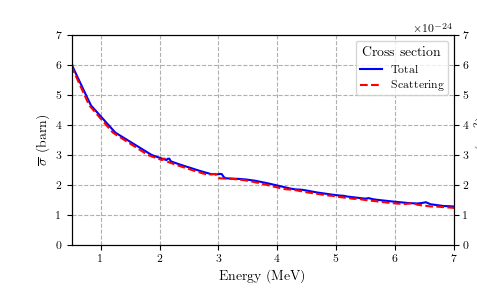

In [50]:
# Plot microscopic cross section
barn_to_cm2 = 1e-24
fig, (ax1)= plt.subplots(nrows=1, ncols=1)
ax2 = ax1.twinx()
ax1.grid(True, which='major', linestyle='--', zorder=0)
ax1.grid(True, which='minor', linestyle='--', zorder=0)
ax1.plot(data_ne213a['total'][0]*1e-6, data_ne213a['total'][1], color='blue', linestyle='-', label='Total')
ax1.plot(data_ne213a['scattering'][0]*1e-6, data_ne213a['scattering'][1], color='red', linestyle='--', label='Scattering')
ax1.set_xlabel('Energy (MeV)')
ax1.set_xlim(0.5, 7)
ax1.set_ylim(0, 7)
ax2.set_ylim(0, 7*barn_to_cm2)
ax1.set_ylabel('$\overline{\sigma}$ (barn)')
ax2.set_ylabel('$\overline{\sigma}$ (cm$^2$)')
ax1.legend(loc=1, title='Cross section')
fig.savefig('output/microscopic_cross_sections_ne213a.pdf', bbox_inches='tight')

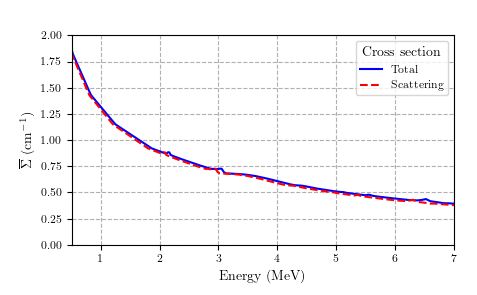

In [51]:
# Plot macroscopic cross section
barn_to_cm2 = 1e-24
total_energies_in_MeV = data_ne213a['total'][0] * 1e-6
scattering_energies_in_MeV = data_ne213a['scattering'][0] * 1e-6
total_macro_cross = data_ne213a['total'][1] * density_ne213a * barn_to_cm2
scattering_macro_cross = data_ne213a['scattering'][1] * density_ne213a * barn_to_cm2
fig, (ax1)= plt.subplots(nrows=1, ncols=1)
ax1.grid(True, which='major', linestyle='--', zorder=0)
ax1.grid(True, which='minor', linestyle='--', zorder=0)
ax1.plot(total_energies_in_MeV, total_macro_cross, color='blue', linestyle='-', label='Total')
ax1.plot(scattering_energies_in_MeV, scattering_macro_cross, color='red', linestyle='--', label='Scattering')
ax1.set_xlabel('Energy (MeV)')
ax1.set_xlim(0.5, 7)
ax1.set_ylim(0, 2)
ax1.set_ylabel('$\overline{\Sigma}$ (cm$^{-1}$)')
ax1.legend(loc=1, title='Cross section')
fig.savefig('output/macroscopic_cross_sections_ne213a.pdf', bbox_inches='tight')

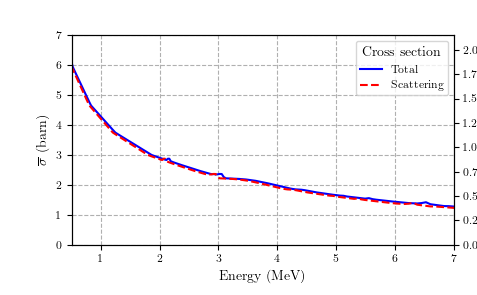

In [52]:
# Plot microscopic and macrospoic cross section
barn_to_cm2 = 1e-24
fig, (ax1)= plt.subplots(nrows=1, ncols=1)
ax2 = ax1.twinx()
ax1.grid(True, which='major', linestyle='--', zorder=0)
ax1.grid(True, which='minor', linestyle='--', zorder=0)
ax1.plot(data_ne213a['total'][0]*1e-6, data_ne213a['total'][1], color='blue', linestyle='-', label='Total')
ax1.plot(data_ne213a['scattering'][0]*1e-6, data_ne213a['scattering'][1], color='red', linestyle='--', label='Scattering')
ax1.set_xlabel('Energy (MeV)')
ax1.set_xlim(0.5, 7)
ax1.set_ylim(0, 7)
ax2.set_ylim(0, 7*barn_to_cm2*density_ne213a)
ax1.set_ylabel('$\overline{\sigma}$ (barn)')
ax2.set_ylabel('$\overline{\Sigma}$ (cm$^{-1}$)')
ax1.legend(loc=1, title='Cross section')
fig.savefig('output/microscopic_and_macroscopic_cross_sections_ne213a.pdf', bbox_inches='tight')

# Acknowledgements<a class="anchor" id="ACKNOWLEDGEMENTS"></a>

Computing resources provided by DMSC Computing Centre (https://europeanspallationsource.se/data-management-software-centre).